In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from midiutil import MIDIFile

import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *
from python.signal_processing import *
from python.post_processing import activations2beats
from python.models import TCN_Davies

In [2]:
sr, signal = wavfile.read('/Users/juliusrichter/Desktop/A_travis snippet.wav', mmap=False)

signal = remix(signal)

In [4]:
# process

nhid = 16; levels = 10; kernel_size = 5; dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCN_Davies(nhid, levels, kernel_size, dropout)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('../models/TCN_Davies_0254_0.2.pt', map_location=device))
model.eval();

sr = 44100
frame_size = 2048
frame_rate = 100
hop_size = sr/frame_rate
window = np.hamming(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sr)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

start = time.time()
num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
frames = []    

# Slice audio into frames
for index in range(num_frames):
    frames.append(signal_frame(signal, index, frame_size, hop_size))

# Compute FFT    
fft = np.empty((num_frames, num_fft_bins), np.complex64)
for f, frame in enumerate(frames):
    fft_signal = np.multiply(frame, window)
    fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

abs_fft = np.square(np.abs(fft))

filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)
filt_spec = filt_spec[:,~np.all(filt_spec == 0, axis=0)]
input = torch.tensor(filt_spec, dtype=torch.float32) 

input = input.view(1, len(input),-1)

# pickle.dump(input, open('/Users/juliusrichter/Desktop/A2 - Yuki No Genso (Snow Fantasy).npy', 'wb'), protocol=2)

with torch.no_grad():        
    out = model(input)
        

activations = np.exp(np.array(out[0,1,:]))

pred_beats = activations2beats(activations)

     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))


Elapsed time: 0 min and 0 s


In [5]:
input.shape

torch.Size([1, 259, 81])

In [5]:
# play predictions

signal = signal / np.max(np.abs(signal))
        
metronome = clicks(pred_beats, sr=sr, length=len(signal))

signal = signal + 1.0*metronome
signal = signal / np.max(np.abs(signal))

# scipy.io.wavfile.write('/Users/juliusrichter/Desktop/Ca Tru - Traditional Vietnamese (Clicks).wav', sr, metronome)
        
ipd.Audio(signal, rate=sr)

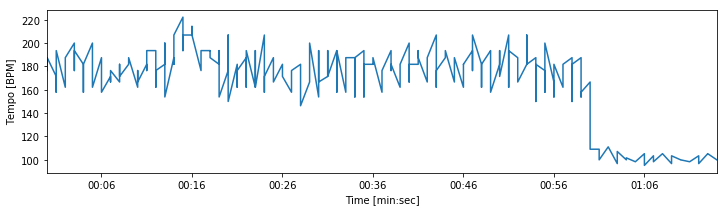

In [22]:
# tempo curve 

import datetime
import matplotlib.dates as mdates

# year, month, day[, hour[, minute[, second[, microsecond[, tzinfo]]]]]
t = np.array([datetime.datetime(2019, 9, 28, 0, int(i/60), int(i % 60)) for i in pred_beats[:-1]])
tempocurve = 1.0 /np.diff(pred_beats) * 60

plt.figure(figsize=(12,3), num=0)
plt.plot(t, tempocurve)
plt.xlim(t[0], t[-1])
plt.xlabel('Time [min:sec]');
plt.ylabel('Tempo [BPM]');
plt.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'));


In [23]:
MyMIDI = MIDIFile(1)  # One track, defaults to format 1
MyMIDI.addTempo(track=0, time=0, tempo=60)
MyMIDI.addTimeSignature(track=0, time=1+pred_beats[0], numerator=4, denominator=2,
                        clocks_per_tick=8, notes_per_quarter=8)

for i, tempo in enumerate(tempocurve):
    MyMIDI.addTempo(track=0, time=i+1+pred_beats[0], tempo=tempo)
    MyMIDI.addNote(track=0, channel=0, pitch=60, time=i+1+pred_beats[0], 
                   duration=0.5, volume=100)

with open('/Users/juliusrichter/Desktop/tempo_curve.mid', 'wb') as output_file:
    MyMIDI.writeFile(output_file)

In [16]:
pred_beats[0]

0.18